**Problem Statement & Understanding the Dataset**

---
- you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote

**The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:**

1. `Thumbs up`:  Increase the volume
2. `Thumbs down`: Decrease the volume
3. `Left swipe`: 'Jump' backwards 10 seconds
4. `Right swipe`: 'Jump' forward 10 seconds  
5. `Stop`: Pause the movie

Each video is a sequence of 30 frames (or images)

- The training data consists of a few hundred videos categorised into one of the five classes. Each video (**typically 2-3 seconds long**) is divided into a **sequence of 30 frames(images)**. These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use.

# Importing required library

In [ ]:
import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import datetime
import random as rn
import PIL

from PIL import Image, ImageFilter, ImageEnhance
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.models import Sequential, Model #type: ignore
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Bidirectional, BatchNormalization, Activation, Dropout, GlobalAveragePooling2D, GlobalAveragePooling3D, ConvLSTM2D #type: ignore
from keras.layers import Conv2D, Conv3D, MaxPooling2D, MaxPooling3D #type: ignore
from tensorflow.keras.optimizers import Adam #type: ignore
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau #type: ignore
from keras import optimizers


import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Dictionary to store the module names and their versions
module_versions = {
    'os': 'Standard Library, no version',
    'numpy': np.__version__,
    'matplotlib': matplotlib.__version__,  # Use matplotlib instead of plt
    'datetime': 'Standard Library, no version',
    'random': 'Standard Library, no version',
    'Pillow (PIL)': PIL.__version__,
    'tensorflow': tf.__version__,
    'keras': keras.__version__
}

# Print the versions of the modules
for module, version in module_versions.items():
    print(f"{module}: {version}")

os: Standard Library, no version
numpy: 1.19.4
matplotlib: 3.5.0
datetime: Standard Library, no version
random: Standard Library, no version
Pillow (PIL): 9.0.1
tensorflow: 2.7.0
keras: 2.7.0


In [ ]:
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

# Data Processing

First we need to fetch folder path using test.csv & val.csv

In [ ]:
# train and validatiaon data creator with ablation
# when ablation is 7, then 7 folders for each label will be selected.
def get_data(path, ablation=None):
  """
  Using the train.csv and val.csv get file path of the training and
  validation data based on class. Using ablation parameter we can select no of
  class or limit the class count.

  Args:
      path (str): A string representing the path to the directory containing
                  the images.
      ablation (int): A int representing the no of class to consider but it is
      optional based on requirement we can use it. when ablation is 7,
      then 7 folders for each label will be selected

  Returns:
      Folder path of each class.
  """
  train_doc_path = np.random.permutation(open(path+'train.csv').readlines())
  val_doc_path = np.random.permutation(open(path+'val.csv').readlines())
  train_data = []
  val_data = []
  # when ablation is None pass full training and val data
  if ablation is not None:
    counts = np.zeros(5) # count for loading folders for 5 classes
    # iterating train doc
    for doc in train_doc_path:
      lable = int(doc.strip().split(';')[2])
      if counts[lable] < ablation:
        train_data.append(doc)
        counts[lable] += 1
        counts = np.zeros(5)

    # iterating val doc
    for doc in val_doc_path:
      lable = int(doc.strip().split(';')[2])
      if counts[lable] < ablation:
        val_data.append(doc)
        counts[lable] += 1
  else:
    train_data, val_data = train_doc_path, val_doc_path
  return train_data, val_data

In [ ]:
train_doc_path, val_doc_path = get_data('/home/datasets/Project_data/', ablation=None)

In [ ]:
# sequence ids
# selecting alternate frames from 7 to 26.
seq_idx = range(7,26,2)
# image dimensions
dim_x = 120
dim_y = 120

# Generator

In [ ]:
# generator with augmentation for train data
def generator(source_path, folder_list, batch_size, is_train=False, augmention=False, debug=False):
    img_idx = seq_idx  # Assuming seq_idx is defined elsewhere
    x = len(img_idx)
    y = dim_x
    z = dim_y

    while True:
        # Doubling the data for augmentation
        if is_train and augmention:
            t = np.concatenate((np.random.permutation(folder_list), np.random.permutation(folder_list)))
        else:
            t = np.random.permutation(folder_list)

        num_batches = len(t) // batch_size + (1 if len(t) % batch_size != 0 else 0)

        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, x, y, z, 3), dtype=np.float32)
            batch_labels = np.zeros((batch_size, 5), dtype=np.float32)

            for folder in range(batch_size):
                if debug:
                    plt.figure(figsize=(20, 5))

                folder_idx = folder + (batch * batch_size)
                if folder_idx >= len(t):
                    break

                # Convert to string
                folder_str = t[folder_idx].item()
                folder_path = os.path.join(source_path, folder_str.strip().split(';')[0])
                # Get all images in the folder
                imgs = os.listdir(folder_path)  # Get all images in the folder

                # Randomly enabling augmentation
                aug_type = None
                if is_train and augmention and rn.randint(0, 1) == 1:
                    # Randomly selecting augmentation type
                    aug_type = rn.randint(0, 4)

                for idx, item in enumerate(img_idx):
                    if item < len(imgs):
                        image_path = os.path.join(folder_path, imgs[item])
                        # Load image as a PIL Image
                        image = Image.open(image_path).convert("RGB")
                    else:
                        print("Item index out of bounds for imgs array.")

                    # Make sure image is a PIL Image
                    if isinstance(image, Image.Image):

                        # Get the width and height
                        width, height = image.size

                        # Crop logic
                        if width > height:  # width > height
                            diff_px = width - height
                            crop_start = diff_px // 2
                            crop_end = crop_start + height
                            image = image.crop((crop_start, 0, crop_end, height))
                        elif height > width:  # height > width
                            diff_px = height - width
                            crop_start = diff_px // 2
                            crop_end = crop_start + width
                            image = image.crop((0, crop_start, width, crop_end))

                        # Resize the PIL image
                        resized_im = image.resize((dim_x, dim_y), Image.LANCZOS)

                        # Apply augmentation if applicable
                        aug_image = resized_im.copy()
                        if aug_type is not None:
                            if aug_type == 0:  # Edge Enhancement
                                aug_image = aug_image.filter(ImageFilter.EDGE_ENHANCE)
                            elif aug_type == 1:  # Adding Gaussian Blur
                                aug_image = aug_image.filter(ImageFilter.GaussianBlur(1))
                            elif aug_type == 2:  # Enhancing image detailing
                                aug_image = aug_image.filter(ImageFilter.DETAIL)
                            elif aug_type == 3:  # Sharpening image
                                aug_image = aug_image.filter(ImageFilter.SHARPEN)
                            elif aug_type == 4:  # Brightness enhancement
                                enhancer = ImageEnhance.Brightness(aug_image)
                                aug_image = enhancer.enhance(1.5)

                        if debug:
                            # Plot original images in the first row (1, 10, idx+1)
                            plt.subplot(2, 10, idx + 1)
                            plt.imshow(np.array(resized_im).astype('uint8'))
                            plt.title(f"Original {idx+1}")
                            plt.axis('off')  # Hide axis for clarity

                            # Plot augmented images in the second row (2, 10, idx+11)
                            plt.subplot(2, 10, idx + 11)
                            plt.imshow(np.array(aug_image).astype('uint8'))
                            plt.title(f"Augmented {idx+1}")
                            plt.axis('off')  # Hide axis for clarity

                        # Convert the resized image to a NumPy array and normalize
                        resized_im = np.array(resized_im, dtype=np.float32)
                        aug_image = np.array(aug_image, dtype=np.float32)

                        # Normalize and store in batch data
                        batch_data[folder, idx, :, :, 0] = resized_im[:, :, 0] / 255
                        batch_data[folder, idx, :, :, 1] = resized_im[:, :, 1] / 255
                        batch_data[folder, idx, :, :, 2] = resized_im[:, :, 2] / 255

                    else:
                        raise TypeError(f"Expected an image of type PIL.Image but got {type(image)}.")

                batch_labels[folder, int(folder_str.strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [ ]:
train_path = '/home/datasets/Project_data/train'
val_path =  '/home/datasets/Project_data/val'

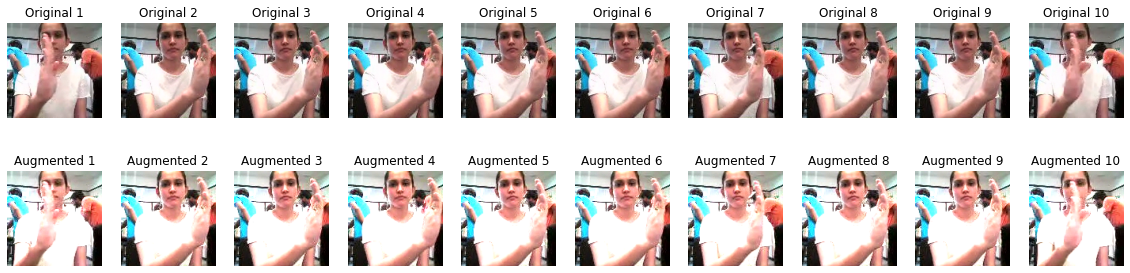

In [ ]:
# testing generative
test_gen = generator(train_path, train_doc_path, 1, is_train = True,
                     augmention = True, debug = True)
d = next(test_gen)[0]

# Model

The model will use 3D Convolutional Layers (Conv3D) and MaxPooling3D layers, not the 2D counterparts (Conv2D and MaxPooling2D), to effectively process spatiotemporal data.

Additionally, when building a hybrid Conv2D + RNN model, ensure that you use the TimeDistributed wrapper for applying the convolutional layers across temporal sequences. This will allow the 2D convolutions to be applied on each time step independently, before feeding the outputs into an RNN layer (like LSTM or GRU).

The last layer of the model should use softmax as the activation function, as this will be a classification problem, and softmax will output probabilities for each class.

The objective is to design a model that can achieve good accuracy while minimizing the number of parameters, ensuring that it can fit within the memory constraints of a webcam or low-memory device. The model should be lightweight, efficient, and optimized for real-time performance.

### **`Experiment - 1`**

#### Conv3D with 2 layers

In [ ]:
import datetime

# Batch size for training. You can experiment with this value for optimal performance.
batch_size = 100

# Whether to enable data augmentation. Useful for improving model generalization, especially on small datasets.
enable_augmentation = False

# Sequence indices: selecting alternate frames between indices 7 to 26 (with a step of 2)
# This will pick frames 7, 9, 11, ..., 25 from a video or sequence.
seq_idx = range(7, 26, 2)

# Image dimensions for resizing the input data. This will be the resolution of the input images.
dim_x = 120  # width of input image
dim_y = 120  # height of input image

# A specific experiment number or ablation study identifier for keeping track of this experiment.
ablationNo = 20

# Number of epochs to train the model. You can experiment with this value to see how training evolves over time.
num_epochs = 20

# Capture the current date and time for logging and model saving purposes.
curr_dt_time = datetime.datetime.now()

# Printing the configuration details for logging purposes
print(f"Experiment Settings:\n \n1. Batch Size: {batch_size}\n2. Data Augmentation: {enable_augmentation}\n"
      f"3. Sequence Indices: {list(seq_idx)}\n4. Image Dimensions: {dim_x}x{dim_y}\n"
      f"5. Ablation Number: {ablationNo}\n6. Number of Epochs: {num_epochs}\n"
      f"7. Current Date & Time: {curr_dt_time}")


Experiment Settings:
 
1. Batch Size: 100
2. Data Augmentation: False
3. Sequence Indices: [7, 9, 11, 13, 15, 17, 19, 21, 23, 25]
4. Image Dimensions: 120x120
5. Ablation Number: 20
6. Number of Epochs: 20
7. Current Date & Time: 2024-10-01 03:38:54.220617


In [ ]:
train_doc_path, val_doc_path = get_data('/home/datasets/Project_data/', ablation=ablationNo)

Let add generator to train & validation data set, which we will use in fit_generator

In [ ]:
# Initialize the training data generator
train_generator = generator(train_path, train_doc_path, batch_size, is_train=True, augmention=enable_augmentation)

# Initialize the validation data generator
val_generator = generator(val_path, val_doc_path, batch_size)


In [ ]:
#input shape for the st layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)

Function - get_steps_per_epoch

In [ ]:
def get_steps_per_epoch(num_train_sequences, num_val_sequences, batch_size):
  if (num_train_sequences%batch_size) == 0:
      steps_per_epoch = int(num_train_sequences/batch_size)
  else:
      steps_per_epoch = (num_train_sequences//batch_size) + 1

  if (num_val_sequences%batch_size) == 0:
      validation_steps = int(num_val_sequences/batch_size)
  else:
      validation_steps = (num_val_sequences//batch_size) + 1

  return steps_per_epoch, validation_steps

In [ ]:
#multiply number train seq by 2 when using augmentation
multiplier = 1
if enable_augmentation:
    multiplier = 2
num_train_sequences = len(train_doc_path)*multiplier
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc_path)
print('# validation sequences =', num_val_sequences)

steps_per_epoch_1, validation_steps_1 = get_steps_per_epoch(num_train_sequences,num_val_sequences,batch_size)

# training sequences = 663
# validation sequences = 94


In [ ]:
# Define Model
model = Sequential()

# First Convolutional Block with MaxPooling
model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))

# Second Convolutional Block with MaxPooling
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=2))

# Flatten for fully connected layers
model.add(Flatten())

# Fully connected layer with L2 regularization and Dropout to prevent overfitting
model.add(Dense(256, activation='relu'))

# Output layer for 5-class classification
model.add(Dense(5, activation='softmax'))

2024-10-01 03:38:56.773351: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-10-01 03:38:56.773430: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [ ]:
# Compile the model

model.compile(
    optimizer=Adam(learning_rate=0.001),  # You can adjust the learning rate if needed
    loss='categorical_crossentropy',      # Loss function for multi-class classification
    metrics=['categorical_accuracy']      # Metrics to track during training
  )

# Model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 8, 118, 118, 32)   2624      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 4, 59, 59, 32)    0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 2, 57, 57, 64)     55360     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 1, 28, 28, 64)    0         
 3D)                                                             
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 256)               1

In [ ]:
# Define Model Name:
model_name = 'model_init_exp_1' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

# Create the filepath:
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
                             save_best_only=False, save_weights_only=False,
                             mode='auto', save_freq='epoch')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5,
                       min_lr=0.001, verbose=1)

callbacks_list = [checkpoint, LR]

In [ ]:
# Training the Model:
# Ensure to use callbacks for early stopping during training:

history1 = model.fit(train_generator,
                     steps_per_epoch=steps_per_epoch_1,
                     epochs=num_epochs,
                     verbose=1,
                     callbacks=callbacks_list,
                     validation_data=val_generator,
                     validation_steps=validation_steps_1,
                     class_weight=None,
                     initial_epoch=0)

Epoch 1/20


2024-09-30 04:36:41.264120: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


7/7 [==============================] - ETA: 0s - loss: 2.7669 - categorical_accuracy: 0.2214
Epoch 00001: saving model to model_init_exp_1_2024-09-3004_36_32.724727/model-00001-2.76688-0.22143-1.50569-0.20000.h5
7/7 [==============================] - 40s 6s/step - loss: 2.7669 - categorical_accuracy: 0.2214 - val_loss: 1.5057 - val_categorical_accuracy: 0.2000 - lr: 0.0010
Epoch 2/20
7/7 [==============================] - ETA: 0s - loss: 1.4701 - categorical_accuracy: 0.1957
Epoch 00002: saving model to model_init_exp_1_2024-09-3004_36_32.724727/model-00002-1.47011-0.19571-1.35555-0.21000.h5
7/7 [==============================] - 24s 4s/step - loss: 1.4701 - categorical_accuracy: 0.1957 - val_loss: 1.3556 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/20
7/7 [==============================] - ETA: 0s - loss: 1.3450 - categorical_accuracy: 0.2671
Epoch 00003: saving model to model_init_exp_1_2024-09-3004_36_32.724727/model-00003-1.34501-0.26714-1.21139-0.40000.h5
7/7 [=========

Function - Model Plot (Accuracy & loss) of Training and Validation data set

In [ ]:
# plot_history function:

def plot_history(history):
    # Create a figure with two subplots to visualize loss and accuracy history
  plt.figure(figsize=(20,6))

  # First subplot for model loss
  ax1 = plt.subplot(121)
  ax1 = plt.plot(history.history['loss']) # Plot training loss
  h1ax1 = plt.plot(history.history['val_loss'])  # Plot validation loss
  plt.title('model loss')  # Title of the plot
  plt.ylabel('loss')   # Label y-axis as 'Loss'
  plt.xlabel('epoch')  # Label x-axis as 'Epoch'
  plt.legend(['train', 'validation'], loc='lower left')

  # Second subplot for model accuracy
  ax2 = plt.subplot(122)  # Right subplot (1 row, 2 columns, 2nd plot)
  ax2 = plt.plot(history.history['categorical_accuracy'])  # Plot training accuracy
  ax2 = plt.plot(history.history['val_categorical_accuracy'])  # Plot validation accuracy
  plt.title('Model Accuracy')  # Title of the plot
  plt.ylabel('Categorical Accuracy')  # Label y-axis as 'Accuracy'
  plt.xlabel('Epoch')  # Label x-axis as 'Epoch'
  plt.legend(['Train', 'Validation'], loc='lower left')  # Add legend for training and validation accuracy

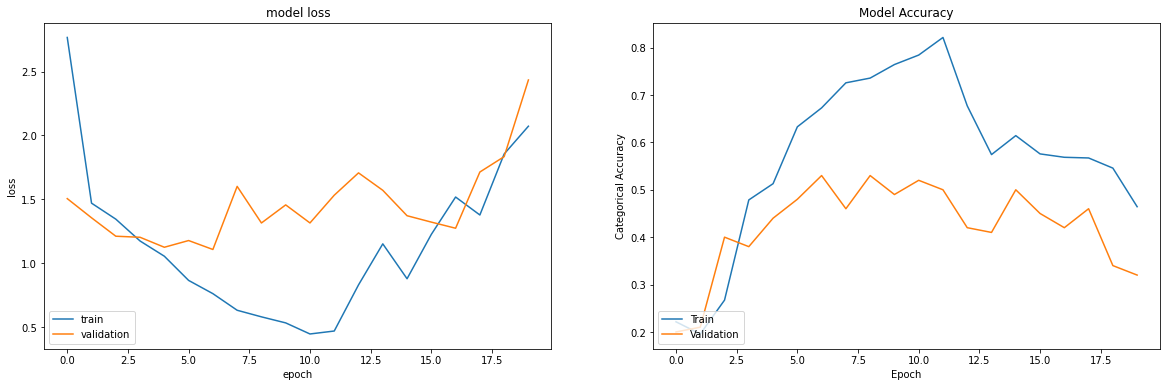

In [ ]:
model_1 = plot_history(history1)

**Summary Experiment - 1**

**Image Description:**

The image presents two plots: one depicting the model loss and the other showing the model accuracy over 20 epochs. The x-axis in both plots represents the epochs, while the y-axis shows the loss and accuracy, respectively. Both plots include lines for the training and validation sets.

**Analysis**

1. **Model Loss (Left Plot):**
   - The training loss (blue line) initially decreases, indicating that the model is learning from the data. However, after around 15 epochs, it begins to increase, suggesting overfitting.
   - The validation loss (orange line) decreases up to a point and then starts to increase, also indicating overfitting. The fact that it increases even more significantly suggests that the model is struggling to generalize well.

2. **Model Accuracy (Right Plot):**
   - The training accuracy increases steadily and peaks around 10 epochs, after which it starts decreasing. This drop also indicates overfitting.
   - The validation accuracy reaches a maximum at around 7 epochs and then declines, further suggesting overfitting.

3. **Scores**
   - Categorical Accuracy - 0.4643
   - Categorical Loss - 2.0724
   - Val_Categorical Accuracy - 0.3200
   - Val_Categorical Loss - 2.4344

**Conclusion**:
- **Overfitting:** The model appears to overfit the training data, as indicated by the divergence between training and validation loss/accuracy after a certain number of epochs. This could be due to the model being too complex for the amount of data or lacking regularization.
- We have increased the batch_size to `32`

### **`Experiment - 2`**

#### Conv3D with 2 layers

In [ ]:
batch_size = 32 # experiment with the batch size
enable_augmentation = False # augmentation of Data
# sequence ids
# selecting alternate frames from 7 to 26.
seq_idx = range(7,26,2)
# image dimensions
dim_x = 120
dim_y = 120
ablationNo = 20
num_epochs = 20 # choose the number of epochs
curr_dt_time = datetime.datetime.now()

In [ ]:
train_generator = generator(train_path, train_doc_path, batch_size, is_train = True,
                            augmention = enable_augmentation)
val_generator = generator(val_path, val_doc_path, batch_size)

In [ ]:
#input shape for the st layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)

In [ ]:
#multiply number train seq by 2 when using augmentation
multiplier = 1
if enable_augmentation:
    multiplier = 2
num_train_sequences = len(train_doc_path)*multiplier
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc_path)
print('# validation sequences =', num_val_sequences)

steps_per_epoch_1, validation_steps_1 = get_steps_per_epoch(num_train_sequences,
                                                            num_val_sequences,
                                                            batch_size)

# training sequences = 663
# validation sequences = 94


In [ ]:
# Create Model
model = Sequential()

# First Conv3D layer: 32 filters with a 3x3x3 kernel for 3D spatial feature extraction
model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(MaxPooling3D(pool_size=2))

# Second Conv3D layer: 64 filters for deeper 3D feature extraction
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=2))

# Flatten layer: Converts the 3D feature maps into 1D feature vectors
model.add(Flatten())

# Dense layer: 256 units for fully connected layer with ReLU activation
model.add(Dense(256, activation='relu'))

# Output layer: 5 units (for 5 classes) with softmax activation for classification
model.add(Dense(5, activation='softmax'))

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),  # You can adjust the learning rate if needed
    loss='categorical_crossentropy',      # Loss function for multi-class classification
    metrics=['categorical_accuracy']      # Metrics to track during training
)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_2 (Conv3D)           (None, 8, 118, 118, 32)   2624      
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 4, 59, 59, 32)    0         
 3D)                                                             
                                                                 
 conv3d_3 (Conv3D)           (None, 2, 57, 57, 64)     55360     
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 1, 28, 28, 64)    0         
 3D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 50176)             0         
                                                                 
 dense_2 (Dense)             (None, 256)              

In [ ]:
model_name = 'model_init_exp_2' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

# Create the filepath:
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
                             save_best_only=False, save_weights_only=False,
                             mode='auto', save_freq='epoch')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5,
                       min_lr=0.001, verbose=1)

callbacks_list = [checkpoint, LR]

In [ ]:
history2 = model.fit(train_generator,
                     steps_per_epoch=steps_per_epoch_1,
                     epochs=num_epochs,
                     verbose=1,
                     callbacks=callbacks_list,
                     validation_data=val_generator,
                     validation_steps=validation_steps_1,
                     class_weight=None,
                     initial_epoch=0)

Epoch 1/20
21/21 [==============================] - ETA: 0s - loss: 1.7774 - categorical_accuracy: 0.2440
Epoch 00001: saving model to model_init_exp_2_2024-09-3004_55_09.533166/model-00001-1.77736-0.24405-1.42773-0.38542.h5
21/21 [==============================] - 25s 1s/step - loss: 1.7774 - categorical_accuracy: 0.2440 - val_loss: 1.4277 - val_categorical_accuracy: 0.3854 - lr: 0.0010
Epoch 2/20
21/21 [==============================] - ETA: 0s - loss: 1.3067 - categorical_accuracy: 0.4628
Epoch 00002: saving model to model_init_exp_2_2024-09-3004_55_09.533166/model-00002-1.30674-0.46280-1.35988-0.38542.h5
21/21 [==============================] - 23s 1s/step - loss: 1.3067 - categorical_accuracy: 0.4628 - val_loss: 1.3599 - val_categorical_accuracy: 0.3854 - lr: 0.0010
Epoch 3/20
21/21 [==============================] - ETA: 0s - loss: 1.0730 - categorical_accuracy: 0.5610
Epoch 00003: saving model to model_init_exp_2_2024-09-3004_55_09.533166/model-00003-1.07301-0.56101-1.14967-0.46

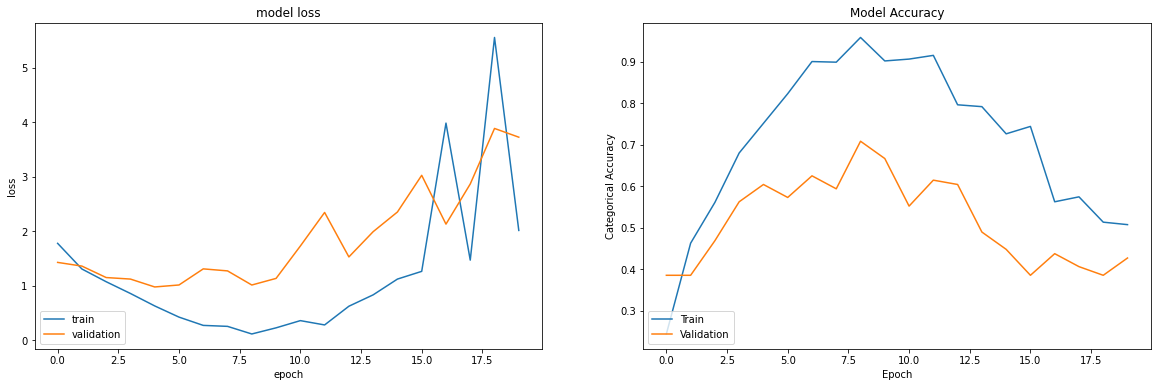

In [ ]:
model_2 = plot_history(history2)

**Summary Experiment - 2**

**Analysis**

**Image Description:**

The image presents two plots: one depicting the model loss and the other showing the model accuracy over 20 epochs. The x-axis in both plots represents the epochs, while the y-axis shows the loss and accuracy, respectively. Both plots include lines for the training and validation sets.

**Model Loss (Left Plot):**

- **Training Loss:** The training loss initially decreases, indicating that the model is learning from the data. However, around epoch 15, it starts to increase significantly, suggesting overfitting.
- **Validation Loss:** The validation loss also decreases initially but begins to increase around epoch 10, indicating overfitting. This increase is more pronounced than the training loss, confirming the model's struggle to generalize.

**Model Accuracy (Right Plot):**

- **Training Accuracy:** The training accuracy steadily increases until around epoch 15, where it plateaus or slightly decreases, suggesting overfitting.
- **Validation Accuracy:** The validation accuracy reaches a peak around epoch 10 and then declines, further indicating overfitting.

**Scores (Assuming values from the previous analysis):**

- Categorical Accuracy - 0.5074
- Categorical Loss - 2.0146
- Val_Categorical Accuracy - 0.4271
- Val_Categorical Loss - 3.7259
- Here we have observed compared to previous model scores are increased expect Val_Categorical Loss variable


**Conclusion**

- **Overfitting:** The model exhibits clear signs of overfitting, as evidenced by the increasing gap between the training and validation loss/accuracy curves. This suggests that the model is learning the training data too well but struggling to generalize to unseen data.
- **Potential Causes:** This overfitting could be due to several factors, such as a complex model, insufficient training data, or the lack of appropriate regularization techniques.
- In the next model we have added 5 layers and Maxpooling 3D but no change in batch_size, epoch, dimensions and augmentation parameters


### **`Experiment - 3`**

#### Conv3D with 5 layers + Dense


In [ ]:
batch_size = 32 # experiment with the batch size
enable_augmentation = False # augmentation of Data
seq_idx = range(7,26,2)
# image dimensions
dim_x = 120
dim_y = 120
ablationNo = 20
num_epochs = 20 # choose the number of epochs
curr_dt_time = datetime.datetime.now()

In [ ]:
train_generator = generator(train_path, train_doc_path, batch_size, is_train = True,
                            augmention = enable_augmentation)
val_generator = generator(val_path, val_doc_path, batch_size)

In [ ]:
#input shape for the st layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)

In [ ]:
#multiply number train seq by 2 when using augmentation
multiplier = 1
if enable_augmentation:
    multiplier = 2
num_train_sequences = len(train_doc_path)*multiplier
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc_path)
print('# validation sequences =', num_val_sequences)

steps_per_epoch_1, validation_steps_1 = get_steps_per_epoch(num_train_sequences,
                                                            num_val_sequences,
                                                            batch_size)

# training sequences = 663
# validation sequences = 94


In [ ]:
# Create Model:
model = Sequential()

# First Conv3D layer: 32 filters with a 3x3x3 kernel for 3D spatial feature extraction
model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))

# Second Conv3D layer:
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Third Conv3D layer:
model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Fourth Conv3D layer:
model.add(Conv3D(256, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(3, 2, 2)))

# Fifth Conv3D layer:
model.add(Conv3D(512, kernel_size=(3, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Flatten layer:
model.add(Flatten())

# Dense layer:
model.add(Dense(512, activation='relu'))

# Output layer: 5 units (for 5 classes) with softmax activation for classification
model.add(Dense(5, activation='softmax'))

ValueError: Exception encountered when calling layer "max_pooling3d_5" (type MaxPooling3D).

Negative dimension size caused by subtracting 2 from 1 for '{{node max_pooling3d_5/MaxPool3D}} = MaxPool3D[T=DT_FLOAT, data_format="NDHWC", ksize=[1, 2, 2, 2, 1], padding="VALID", strides=[1, 2, 2, 2, 1]](Placeholder)' with input shapes: [?,1,56,56,128].

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 1, 56, 56, 128), dtype=float32)

**Summary Experiment - 3**

**Analysis**

- The error is caused by a negative dimension size during the MaxPooling3D operation, which occurs because the pooling operation is applied to a dimension that is too small to support the specified pool size (ksize=[1, 2, 2, 2, 1]) and stride (strides=[1, 2, 2, 2, 1]).

- In our case, the input shape to the max_pooling3d_5 layer is (None, 1, 56, 56, 128), and you're attempting to apply a pooling operation with a size of 2 along each spatial dimension. Since the first dimension (1) is smaller than the pooling window (2), it leads to a negative output size, resulting in a ValueError.

### **`Experiment - 4`**

#### Conv3D with MaxPooling, Batch_Normalization, Dense and Dropout 0.5

In [ ]:
batch_size = 32 # experiment with the batch size
enable_augmentation = False # augmentation of Data
seq_idx = range(7,26,2)
dim_x = 120
dim_y = 120
ablationNo = None
num_epochs = 50 # choose the number of epochs
curr_dt_time = datetime.datetime.now()

In [ ]:
train_generator = generator(train_path, train_doc_path, batch_size, is_train = True,augmention = enable_augmentation)
val_generator = generator(val_path, val_doc_path, batch_size)

In [ ]:
#input shape for the st layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)

In [ ]:
#multiply number train seq by 2 when using augmentation
multiplier = 1
if enable_augmentation:
    multiplier = 2
num_train_sequences = len(train_doc_path)*multiplier
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc_path)
print('# validation sequences =', num_val_sequences)

steps_per_epoch_1, validation_steps_1 = get_steps_per_epoch(num_train_sequences,
                                                            num_val_sequences,
                                                            batch_size)

# training sequences = 663
# validation sequences = 94


In [ ]:
# Create Model
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),  # You can adjust the learning rate if needed
    loss='categorical_crossentropy',      # Loss function for multi-class classification
    metrics=['categorical_accuracy']      # Metrics to track during training
)
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_7 (Conv3D)           (None, 8, 118, 118, 32)   2624      
                                                                 
 conv3d_8 (Conv3D)           (None, 6, 116, 116, 64)   55360     
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 3, 58, 58, 64)    0         
 3D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 3, 58, 58, 64)    256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 3, 58, 58, 64)     0         
                                                                 
 conv3d_9 (Conv3D)           (None, 1, 56, 56, 128)   

In [ ]:
model_name = 'model_init_exp_4' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

# Create the filepath:
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
                             save_best_only=False, save_weights_only=False,
                             mode='auto', save_freq='epoch')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5,
                       min_lr=0.001, verbose=1)

callbacks_list = [checkpoint, LR]

In [ ]:
history4 = model.fit(train_generator,
                     steps_per_epoch=steps_per_epoch_1,
                     epochs=num_epochs,
                     verbose=1,
                     callbacks=callbacks_list,
                     validation_data=val_generator,
                     validation_steps=validation_steps_1,
                     class_weight=None,
                     initial_epoch=0)

Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 2.4161 - categorical_accuracy: 0.4226
Epoch 00001: saving model to model_init_exp_4_2024-09-3005_07_40.148063/model-00001-2.41608-0.42262-12.80136-0.21875.h5
21/21 [==============================] - 31s 1s/step - loss: 2.4161 - categorical_accuracy: 0.4226 - val_loss: 12.8014 - val_categorical_accuracy: 0.2188 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 0.9077 - categorical_accuracy: 0.6756
Epoch 00002: saving model to model_init_exp_4_2024-09-3005_07_40.148063/model-00002-0.90773-0.67560-6.99337-0.21875.h5
21/21 [==============================] - 23s 1s/step - loss: 0.9077 - categorical_accuracy: 0.6756 - val_loss: 6.9934 - val_categorical_accuracy: 0.2188 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.4368 - categorical_accuracy: 0.8229
Epoch 00003: saving model to model_init_exp_4_2024-09-3005_07_40.148063/model-00003-0.43684-0.82292-3.15560-0.

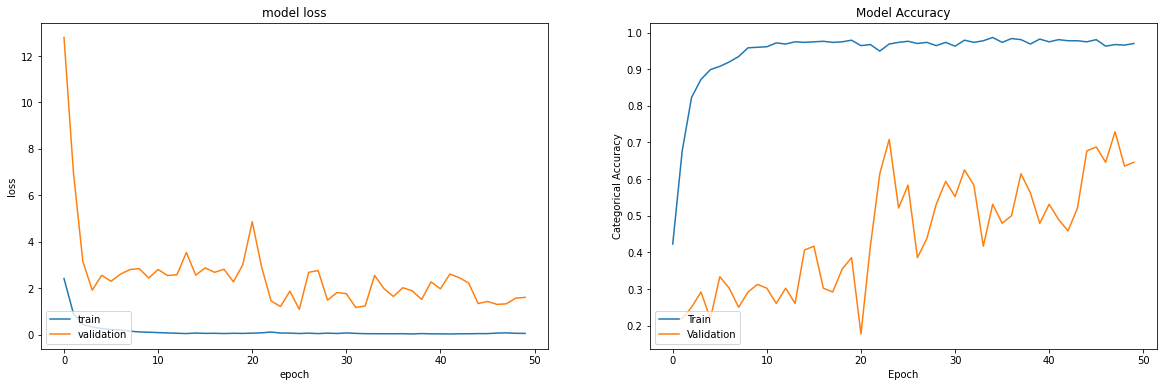

In [ ]:
model_4 = plot_history(history4)

**Summary Experiment - 4**

**Analysis**

**Image Description:**

The image presents two plots: one depicting the model loss and the other showing the model accuracy over 50 epochs. The x-axis in both plots represents the epochs, while the y-axis shows the loss and accuracy, respectively. Both plots include lines for the training and validation sets.

**Model Loss (Left Plot):**

- **Training Loss:** The training loss initially decreases rapidly, indicating that the model is learning effectively from the training data. However, after around 10 epochs, the decrease slows down, and the loss starts to plateau.
- **Validation Loss:** The validation loss also decreases initially but reaches a plateau at a slightly higher level than the training loss. This indicates that the model might be starting to overfit, but the gap between the training and validation loss is relatively small.

**Model Accuracy (Right Plot):**

- **Training Accuracy:** The training accuracy increases steadily and reaches a high level, plateauing around 40 epochs.
- **Validation Accuracy:** The validation accuracy also increases, but it reaches a plateau at a slightly lower level than the training accuracy. This suggests that the model might be overfitting to some extent.

**Scores (Assuming values from the previous analysis):**

- Categorical Accuracy - 0.9702
- Categorical Loss - 0.0526
- Val_Categorical Accuracy - 0.6458
- Val_Categorical Loss - 1.6037
- Here Compared model 2 we have increased the score of Categorical Accuracy & Val_Categorical Accuracy parameters, however model 3 is having error in the MaxPooling

**Conclusion:**

- **Overfitting:** The model shows some signs of overfitting, as evidenced by the gap between the training and validation loss/accuracy curves. However, the gap is relatively small, indicating that the model is generalizing reasonably well. To reduce the overfitting we have deceased the dropout value from 0.5 to 0.2
- **Model Performance:** Overall, the model seems to be performing well, with both training and validation accuracy reaching high levels.

### **`Experiment - 5`**

#### Conv3D with MaxPooling, Batch_Normalization, Dense and Dropout 0.2

In [ ]:
batch_size = 32 # experiment with the batch size
enable_augmentation = False # augmentation of Data
# sequence ids
# selecting alternate frames from 7 to 26.
seq_idx = range(7,26,2)
# image dimensions
dim_x = 120
dim_y = 120
ablationNo = None
num_epochs = 50 # choose the number of epochs
curr_dt_time = datetime.datetime.now()

In [ ]:
train_generator = generator(train_path, train_doc_path, batch_size, is_train = True,
                            augmention = enable_augmentation)
val_generator = generator(val_path, val_doc_path, batch_size)

In [ ]:
#input shape for the st layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)

In [ ]:
#multiply number train seq by 2 when using augmentation
multiplier = 1
if enable_augmentation:
    multiplier = 2
num_train_sequences = len(train_doc_path)*multiplier
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc_path)
print('# validation sequences =', num_val_sequences)

steps_per_epoch_1, validation_steps_1 = get_steps_per_epoch(num_train_sequences,
                                                            num_val_sequences,
                                                            batch_size)

# training sequences = 663
# validation sequences = 94


In [ ]:
# Create Model
model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GlobalAveragePooling3D())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),  # You can adjust the learning rate if needed
    loss='categorical_crossentropy',      # Loss function for multi-class classification
    metrics=['categorical_accuracy']      # Metrics to track during training
)
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_11 (Conv3D)          (None, 8, 118, 118, 32)   2624      
                                                                 
 conv3d_12 (Conv3D)          (None, 6, 116, 116, 64)   55360     
                                                                 
 max_pooling3d_9 (MaxPooling  (None, 3, 58, 58, 64)    0         
 3D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 3, 58, 58, 64)    256       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 3, 58, 58, 64)     0         
                                                                 
 conv3d_13 (Conv3D)          (None, 1, 56, 56, 128)   

In [ ]:
model_name = 'model_init_exp_5' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

# Create the filepath:
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
                             save_best_only=False, save_weights_only=False,
                             mode='auto', save_freq='epoch')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5,
                       min_lr=0.001, verbose=1)

callbacks_list = [checkpoint, LR]

In [ ]:
history5 = model.fit(train_generator,
                     steps_per_epoch=steps_per_epoch_1,
                     epochs=num_epochs,
                     verbose=1,
                     callbacks=callbacks_list,
                     validation_data=val_generator,
                     validation_steps=validation_steps_1,
                     class_weight=None,
                     initial_epoch=0)

Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 1.5273 - categorical_accuracy: 0.3943
Epoch 00001: saving model to model_init_exp_5_2024-09-3005_27_09.799110/model-00001-1.52728-0.39435-2.40517-0.20833.h5
21/21 [==============================] - 23s 1s/step - loss: 1.5273 - categorical_accuracy: 0.3943 - val_loss: 2.4052 - val_categorical_accuracy: 0.2083 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.1779 - categorical_accuracy: 0.5045
Epoch 00002: saving model to model_init_exp_5_2024-09-3005_27_09.799110/model-00002-1.17787-0.50446-2.44673-0.18750.h5
21/21 [==============================] - 22s 1s/step - loss: 1.1779 - categorical_accuracy: 0.5045 - val_loss: 2.4467 - val_categorical_accuracy: 0.1875 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.9847 - categorical_accuracy: 0.5625
Epoch 00003: saving model to model_init_exp_5_2024-09-3005_27_09.799110/model-00003-0.98474-0.56250-1.93070-0.20

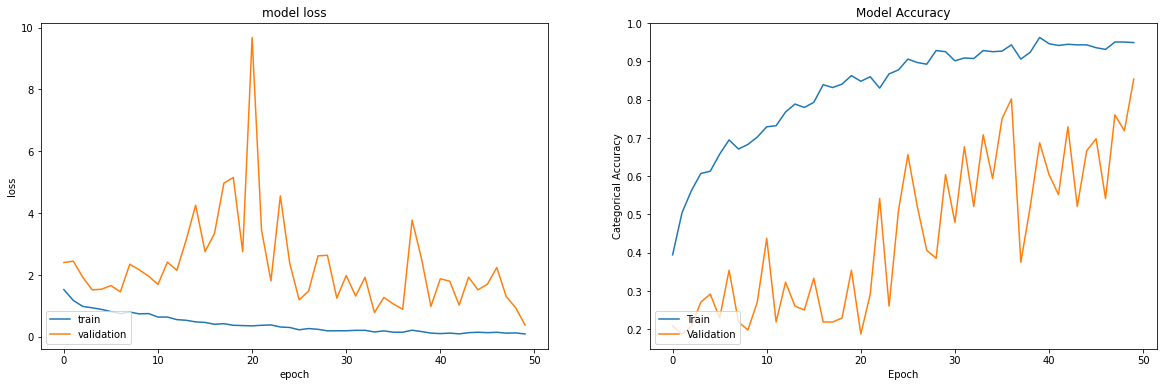

In [ ]:
model_5 = plot_history(history5)

**Summary Experiment - 5**

**Analysis**

**Image Description:**

The image presents two plots: one depicting the model loss and the other showing the model accuracy over 50 epochs. The x-axis in both plots represents the epochs, while the y-axis shows the loss and accuracy, respectively. Both plots include lines for the training and validation sets.

**Model Loss (Left Plot):**

- **Training Loss:** The training loss fluctuates significantly throughout the training process, indicating a lack of stability. There are periods of rapid decreases followed by sudden spikes, suggesting that the model might be struggling to converge.
- **Validation Loss:** The validation loss also fluctuates, but it generally follows the same trend as the training loss. This indicates that the model is not generalizing well and might be overfitting.

**Model Accuracy (Right Plot):**

- **Training Accuracy:** The training accuracy increases steadily, but with some fluctuations. It reaches a relatively high level but shows signs of plateauing towards the end.
- **Validation Accuracy:** The validation accuracy also increases, but it fluctuates more significantly than the training accuracy. There is a clear gap between the training and validation accuracy, indicating overfitting.

**Scores (Assuming values from the previous analysis):**

- Categorical Accuracy - 0.9494
- Categorical Loss - 0.0931
- Val_Categorical Accuracy - 0.8542
- Val_Categorical Loss - 0.3813
- Here Compared to model 4 we have increased the score of Categorical Accuracy & Val_Categorical Accuracy parameters

**Conclusion:**

- **Overfitting:** The model exhibits clear signs of overfitting, as evidenced by the significant gap between the training and validation loss/accuracy curves. This suggests that the model is learning the training data too well but struggling to generalize to unseen data. To reduce overfitting we have add BatchNormalization, GRU with Time Distributed
- **Model Instability:** The fluctuating training loss indicates that the model might be unstable during training, which can contribute to overfitting.


### **`Experiment - 6`**

#### Conv3D + GRU with Time Distributed

In [ ]:
batch_size = 32 # experiment with the batch size
enable_augmentation = False # augmentation of Data
# sequence ids
# selecting alternate frames from 7 to 26.
seq_idx = range(7,26,2)
# image dimensions
dim_x = 120
dim_y = 120
ablationNo = None
num_epochs = 50 # choose the number of epochs
curr_dt_time = datetime.datetime.now()

In [ ]:
train_generator = generator(train_path, train_doc_path, batch_size, is_train = True,
                            augmention = enable_augmentation)
val_generator = generator(val_path, val_doc_path, batch_size)

In [ ]:
#input shape for the st layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)

In [ ]:
#multiply number train seq by 2 when using augmentation
multiplier = 1
if enable_augmentation:
    multiplier = 2
num_train_sequences = len(train_doc_path)*multiplier
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc_path)
print('# validation sequences =', num_val_sequences)

steps_per_epoch_1, validation_steps_1 = get_steps_per_epoch(num_train_sequences,
                                                            num_val_sequences,
                                                            batch_size)

# training sequences = 663
# validation sequences = 94


In [ ]:
# Create Model
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())

model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())

model.add(GRU(128))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),  # You can adjust the learning rate if needed
    loss='categorical_crossentropy',      # Loss function for multi-class classification
    metrics=['categorical_accuracy']      # Metrics to track during training
)
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 118, 118, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization_8 (Batc  (None, 10, 59, 59, 32)   128       
 hNormalization)                                                 
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 57, 57, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 10, 28, 28, 64)  

In [ ]:
model_name = 'model_init_exp_6' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

# Create the filepath:
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
                             save_best_only=False, save_weights_only=False,
                             mode='auto', save_freq='epoch')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5,min_lr=0.001, verbose=1)

callbacks_list = [checkpoint, LR]

In [ ]:
history6 = model.fit(train_generator,
                     steps_per_epoch=steps_per_epoch_1,
                     epochs=num_epochs,
                     verbose=1,
                     callbacks=callbacks_list,
                     validation_data=val_generator,
                     validation_steps=validation_steps_1,
                     class_weight=None,
                     initial_epoch=0)

Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 1.3071 - categorical_accuracy: 0.4613
Epoch 00001: saving model to model_init_exp_6_2024-09-3005_46_09.063814/model-00001-1.30707-0.46131-1.57088-0.20833.h5
21/21 [==============================] - 25s 1s/step - loss: 1.3071 - categorical_accuracy: 0.4613 - val_loss: 1.5709 - val_categorical_accuracy: 0.2083 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 0.9972 - categorical_accuracy: 0.5699
Epoch 00002: saving model to model_init_exp_6_2024-09-3005_46_09.063814/model-00002-0.99722-0.56994-1.54970-0.22917.h5
21/21 [==============================] - 22s 1s/step - loss: 0.9972 - categorical_accuracy: 0.5699 - val_loss: 1.5497 - val_categorical_accuracy: 0.2292 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.7930 - categorical_accuracy: 0.6652
Epoch 00003: saving model to model_init_exp_6_2024-09-3005_46_09.063814/model-00003-0.79296-0.66518-1.55518-0.19

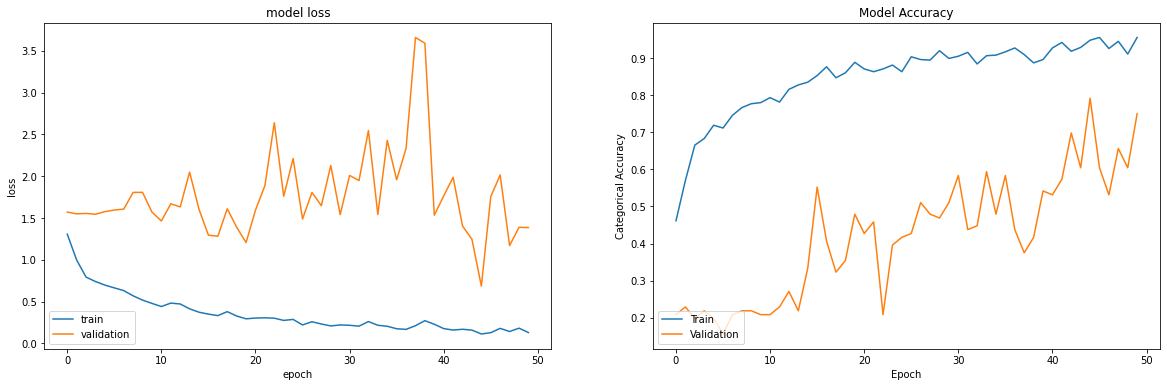

In [ ]:
model_6 = plot_history(history6)

**Summary Experiment - 6**

**Analysis**

**Image Description:**

The image presents two plots: one depicting the model loss and the other showing the model accuracy over 50 epochs. The x-axis in both plots represents the epochs, while the y-axis shows the loss and accuracy, respectively. Both plots include lines for the training and validation sets.

**Model Loss (Left Plot):**

- **Training Loss:** The training loss initially decreases, indicating that the model is learning from the data. However, after around 15 epochs, it starts to increase, suggesting overfitting.
- **Validation Loss:** The validation loss also decreases initially but begins to increase around epoch 10, indicating overfitting. This increase is more pronounced than the training loss, confirming the model's struggle to generalize.

**Model Accuracy (Right Plot):**

- **Training Accuracy:** The training accuracy steadily increases until around 15 epochs, where it plateaus or slightly decreases, suggesting overfitting.
- **Validation Accuracy:** The validation accuracy reaches a peak around 10 epochs and then declines, further indicating overfitting.

**Scores (Assuming values from the previous analysis):**

- Categorical Accuracy - 0.9554
- Categorical Loss - 0.1303
- Val_Categorical Accuracy - 0.7500
- Val_Categorical Loss - 1.3858
- Here Compared to model 5 we have increased the score of Categorical Accuracy but decreased Val_Categorical Accuracy parameters

**Conclusion:**

- **Overfitting:** The model exhibits clear signs of overfitting, as evidenced by the increasing gap between the training and validation loss/accuracy curves. This suggests that the model is learning the training data too well but struggling to generalize to unseen data. Due to overfitting we have add dropout value 0.2
- **Potential Causes:** This overfitting could be due to several factors, such as a complex model, insufficient training data, or the lack of appropriate regularization techniques.

### **`Experiment - 7`**

#### Conv3D + GRU with Time Distributed, Dropout

In [ ]:
batch_size = 32
enable_augmentation = False
seq_idx = range(7,26,2)
dim_x = 120
dim_y = 120
ablationNo = None
num_epochs = 50
curr_dt_time = datetime.datetime.now()

In [ ]:
train_generator = generator(train_path, train_doc_path, batch_size, is_train = True,augmention = enable_augmentation)
val_generator = generator(val_path, val_doc_path, batch_size)

In [ ]:
#input shape for the st layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)

In [ ]:
#multiply number train seq by 2 when using augmentation
multiplier = 1
if enable_augmentation:
    multiplier = 2
num_train_sequences = len(train_doc_path)*multiplier
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc_path)
print('# validation sequences =', num_val_sequences)

steps_per_epoch_1, validation_steps_1 = get_steps_per_epoch(num_train_sequences, num_val_sequences,batch_size)

# training sequences = 663
# validation sequences = 94


In [ ]:
# Create Model
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dense(64, activation='relu')))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(GRU(128))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),  # You can adjust the learning rate if needed
    loss='categorical_crossentropy',      # Loss function for multi-class classification
    metrics=['categorical_accuracy']      # Metrics to track during training
)
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 10, 118, 118, 32)  896      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 10, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization_12 (Bat  (None, 10, 59, 59, 32)   128       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 10, 59, 59, 32)    0         
                                                                 
 time_distributed_8 (TimeDis  (None, 10, 57, 57, 64)   18496     
 tributed)                                            

In [ ]:
model_name = 'model_init_exp_7' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

# Create the filepath:
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
                             save_best_only=False, save_weights_only=False,
                             mode='auto', save_freq='epoch')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5,
                       min_lr=0.001, verbose=1)

callbacks_list = [checkpoint, LR]

In [ ]:
history7 = model.fit(train_generator,
                     steps_per_epoch=steps_per_epoch_1,
                     epochs=num_epochs,
                     verbose=1,
                     callbacks=callbacks_list,
                     validation_data=val_generator,
                     validation_steps=validation_steps_1,
                     class_weight=None,
                     initial_epoch=0)

Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 1.3802 - categorical_accuracy: 0.4360
Epoch 00001: saving model to model_init_exp_7_2024-09-3006_04_45.864417/model-00001-1.38022-0.43601-1.56578-0.20833.h5
21/21 [==============================] - 25s 1s/step - loss: 1.3802 - categorical_accuracy: 0.4360 - val_loss: 1.5658 - val_categorical_accuracy: 0.2083 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.0688 - categorical_accuracy: 0.5595
Epoch 00002: saving model to model_init_exp_7_2024-09-3006_04_45.864417/model-00002-1.06884-0.55952-1.55984-0.33333.h5
21/21 [==============================] - 22s 1s/step - loss: 1.0688 - categorical_accuracy: 0.5595 - val_loss: 1.5598 - val_categorical_accuracy: 0.3333 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.9058 - categorical_accuracy: 0.6161
Epoch 00003: saving model to model_init_exp_7_2024-09-3006_04_45.864417/model-00003-0.90578-0.61607-1.56458-0.20

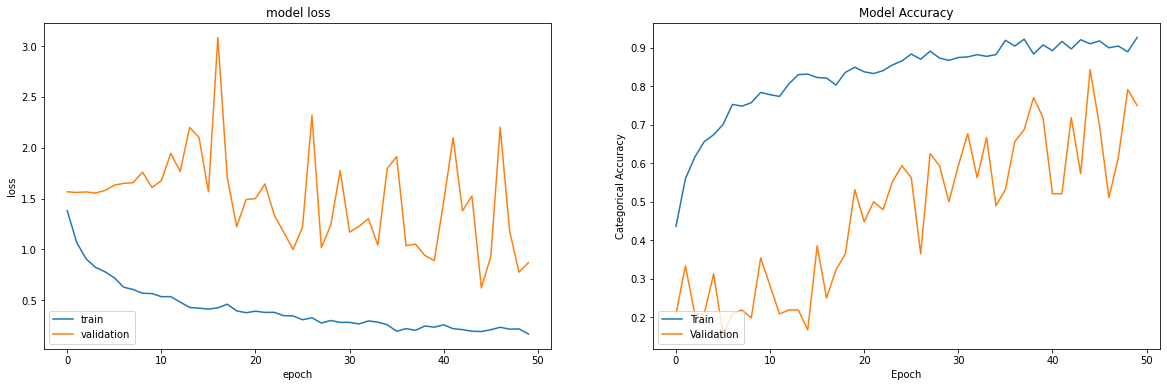

In [ ]:
model_7 = plot_history(history7)

**Summary Experiment - 7**

**Analysis**

**Image Description:**

The image presents two plots: one depicting the model loss and the other showing the model accuracy over 50 epochs. The x-axis in both plots represents the epochs, while the y-axis shows the loss and accuracy, respectively. Both plots include lines for the training and validation sets.

**Model Loss (Left Plot):**

- **Training Loss:** The training loss initially decreases, indicating that the model is learning from the data. However, after around 15 epochs, it starts to increase, suggesting overfitting.
- **Validation Loss:** The validation loss also decreases initially but begins to increase around epoch 10, indicating overfitting. This increase is more pronounced than the training loss, confirming the model's struggle to generalize.

**Model Accuracy (Right Plot):**

- **Training Accuracy:** The training accuracy steadily increases until around 15 epochs, where it plateaus or slightly decreases, suggesting overfitting.
- **Validation Accuracy:** The validation accuracy reaches a peak around 10 epochs and then declines, further indicating overfitting.

**Scores (Assuming values from the previous analysis):**

- Categorical Accuracy - 0.9271
- Categorical Loss - 0.1668
- Val_Categorical Accuracy - 0.7500
- Val_Categorical Loss - 0.8685
- Here Compared to model 6 we have decreased the score of Categorical Accuracy but Val_Categorical Accuracy parameters is stable


**Conclusion:**

- **Overfitting:** The model exhibits clear signs of overfitting, as evidenced by the increasing gap between the training and validation loss/accuracy curves. This suggests that the model is learning the training data too well but struggling to generalize to unseen data.
- **Potential Causes:** This overfitting could be due to several factors, such as a complex model, insufficient training data, or the lack of appropriate regularization techniques.


### **`Experiment - 8`**

### Conv3D with Time Distributed, Dense

In [ ]:
batch_size = 32 # experiment with the batch size
enable_augmentation = False # augmentation of Data
# sequence ids
# selecting alternate frames from 7 to 26.
seq_idx = range(7,26,2)
# image dimensions
dim_x = 120
dim_y = 120
ablationNo = None
num_epochs = 50 # choose the number of epochs
curr_dt_time = datetime.datetime.now()

In [ ]:
train_generator = generator(train_path, train_doc_path, batch_size, is_train = True,
                            augmention = enable_augmentation)
val_generator = generator(val_path, val_doc_path, batch_size)

In [ ]:
#input shape for the st layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)

In [ ]:
#multiply number train seq by 2 when using augmentation
multiplier = 1
if enable_augmentation:
    multiplier = 2
num_train_sequences = len(train_doc_path)*multiplier
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc_path)
print('# validation sequences =', num_val_sequences)

steps_per_epoch_1, validation_steps_1 = get_steps_per_epoch(num_train_sequences,
                                                            num_val_sequences,
                                                            batch_size)

# training sequences = 663
# validation sequences = 94


In [ ]:
# Create Model
model = Sequential()
model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=input_shape))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())

model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())

model.add(TimeDistributed(Conv2D(128, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2))))
model.add(BatchNormalization())

model.add(GlobalAveragePooling3D())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),  # You can adjust the learning rate if needed
    loss='categorical_crossentropy',      # Loss function for multi-class classification
    metrics=['categorical_accuracy']      # Metrics to track during training
)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 118, 118, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 59, 59, 32)   0         
 tributed)                                                       
                                                                 
 batch_normalization (BatchN  (None, 10, 59, 59, 32)   128       
 ormalization)                                                   
                                                                 
 time_distributed_2 (TimeDis  (None, 10, 57, 57, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 10, 28, 28, 64)  

In [ ]:
model_name = 'model_init_exp_8' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

# Create the filepath:
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
                             save_best_only=False, save_weights_only=False,
                             mode='auto', save_freq='epoch')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5,
                       min_lr=0.001, verbose=1)

callbacks_list = [checkpoint, LR]

In [ ]:
history8 = model.fit(train_generator,
                     steps_per_epoch=steps_per_epoch_1,
                     epochs=num_epochs,
                     verbose=1,
                     callbacks=callbacks_list,
                     validation_data=val_generator,
                     validation_steps=validation_steps_1,
                     class_weight=None,
                     initial_epoch=0)

Epoch 1/50


2024-10-01 03:39:37.514075: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.3031 - categorical_accuracy: 0.4777
Epoch 00001: saving model to model_init_exp_8_2024-10-0103_39_30.970761/model-00001-1.30306-0.47768-1.57452-0.17708.h5
21/21 [==============================] - 42s 2s/step - loss: 1.3031 - categorical_accuracy: 0.4777 - val_loss: 1.5745 - val_categorical_accuracy: 0.1771 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 0.9129 - categorical_accuracy: 0.6369
Epoch 00002: saving model to model_init_exp_8_2024-10-0103_39_30.970761/model-00002-0.91289-0.63690-1.54369-0.21875.h5
21/21 [==============================] - 22s 1s/step - loss: 0.9129 - categorical_accuracy: 0.6369 - val_loss: 1.5437 - val_categorical_accuracy: 0.2188 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 0.6911 - categorical_accuracy: 0.7455
Epoch 00003: saving model to model_init_exp_8_2024-10-0103_39_30.970761/model-00003-0.69113-0.74554-1.59136-0.19792.h5
21/2

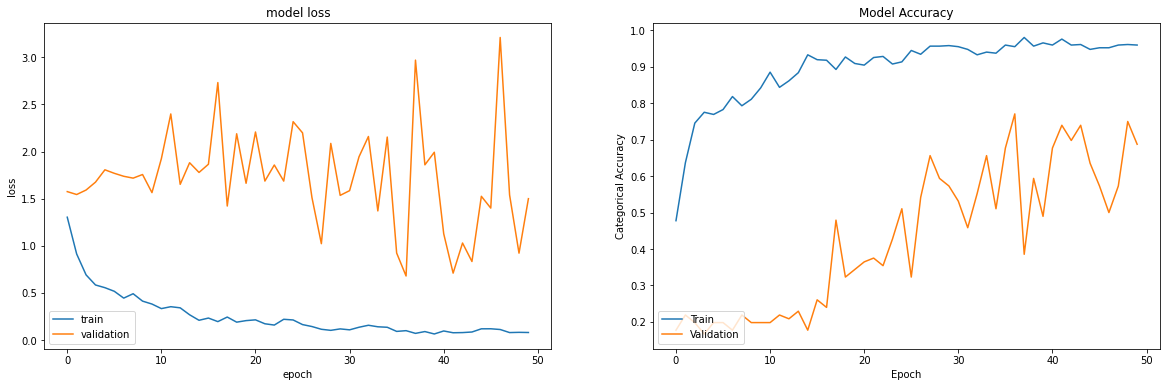

In [ ]:
model_8 = plot_history(history8)

**Summary Experiment -8**

**Analysis**

**Image Description:**

The image presents two plots: one depicting the model loss and the other showing the model accuracy over 50 epochs. The x-axis in both plots represents the epochs, while the y-axis shows the loss and accuracy, respectively. Both plots include lines for the training and validation sets.

**Model Loss (Left Plot):**

- **Training Loss:** The training loss initially decreases rapidly, indicating that the model is learning effectively from the training data. However, after around 15 epochs, the decrease slows down, and the loss starts to fluctuate. There are periods of slight increases and decreases, suggesting that the model might be struggling to converge.
- **Validation Loss:** The validation loss also decreases initially but reaches a plateau at a slightly higher level than the training loss. This indicates that the model might be starting to overfit, but the gap between the training and validation loss is relatively small.

**Model Accuracy (Right Plot):**

- **Training Accuracy:** The training accuracy increases steadily and reaches a high level, plateauing around 40 epochs.
- **Validation Accuracy:** The validation accuracy also increases, but it reaches a plateau at a slightly lower level than the training accuracy. This suggests that the model might be overfitting to some extent.

**Scores (Assuming values from the previous analysis):**

- Categorical Accuracy - 0.9598
- Categorical Loss - 0.0802
- Val_Categorical Accuracy - 0.6875
- Val_Categorical Loss - 1.4998
- Here Compared to model 7 we have increased the score of Categorical Accuracy but decreased in Val_Categorical Accuracy parameters

**Conclusion:**

- **Overfitting:** The model shows some signs of overfitting, as evidenced by the gap between the training and validation loss/accuracy curves. However, the gap is relatively small, indicating that the model is generalizing reasonably well.
- **Model Performance:** Overall, the model seems to be performing well, with both training and validation accuracy reaching high levels.


### **`Experiment - 9`**

### ConvLSTM + Time Distributed

In [ ]:
batch_size = 32
enable_augmentation = False
seq_idx = range(7,26,2)
dim_x = 120
dim_y = 120
ablationNo = None
num_epochs = 50
curr_dt_time = datetime.datetime.now()

In [ ]:
train_generator = generator(train_path, train_doc_path, batch_size, is_train = True,augmention = enable_augmentation)
val_generator = generator(val_path, val_doc_path, batch_size)

In [ ]:
#input shape for the st layer
input_shape = (len(seq_idx), dim_x, dim_y, 3)
np.random.seed(30)

In [ ]:
#multiply number train seq by 2 when using augmentation
multiplier = 1
if enable_augmentation:
    multiplier = 2
num_train_sequences = len(train_doc_path)*multiplier
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc_path)
print('# validation sequences =', num_val_sequences)

steps_per_epoch_1, validation_steps_1 = get_steps_per_epoch(num_train_sequences,
                                                            num_val_sequences,
                                                            batch_size)

# training sequences = 663
# validation sequences = 94


In [ ]:
#Create Model

model = Sequential()

# First TimeDistributed Conv2D layer to extract spatial features from input frames
model.add(TimeDistributed(Conv2D(8, (3, 3), activation='relu'), input_shape=input_shape))
model.add(BatchNormalization())   # Normalize the activations to speed up training and reduce overfitting

# Second TimeDistributed Conv2D layer for deeper feature extraction
model.add(TimeDistributed( Conv2D(16, (3, 3), activation='relu')))
model.add(BatchNormalization()) # Batch normalization to stabilize the learning process

# ConvLSTM2D layer to capture spatiotemporal patterns in sequential frames
model.add(ConvLSTM2D(8, kernel_size=3, return_sequences=False))
model.add(BatchNormalization()) # Batch normalization after ConvLSTM for better generalization

# Global Average Pooling to reduce the dimensionality of feature maps
model.add(GlobalAveragePooling2D())

# Fully connected Dense layer for further processing and classification
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())  # Batch normalization before the final output

# Output layer with softmax activation for multi-class classification (5 classes)
model.add(Dense(5, activation='softmax'))

2024-09-30 07:27:47.858500: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-09-30 07:27:47.858589: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1c:00.0, compute capability: 7.5


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=0.001),  # You can adjust the learning rate if needed
    loss='categorical_crossentropy',      # Loss function for multi-class classification
    metrics=['categorical_accuracy']      # Metrics to track during training
)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 10, 118, 118, 8)  224       
 ibuted)                                                         
                                                                 
 batch_normalization (BatchN  (None, 10, 118, 118, 8)  32        
 ormalization)                                                   
                                                                 
 time_distributed_1 (TimeDis  (None, 10, 116, 116, 16)  1168     
 tributed)                                                       
                                                                 
 batch_normalization_1 (Batc  (None, 10, 116, 116, 16)  64       
 hNormalization)                                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 114, 114, 8)       6

In [ ]:
model_name = 'model_init_exp_9' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

if not os.path.exists(model_name):
    os.mkdir(model_name)

# Create the filepath:
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
                             save_best_only=False, save_weights_only=False,
                             mode='auto', save_freq='epoch')

# write the REducelronplateau code here
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5,
                       min_lr=0.001, verbose=1)

callbacks_list = [checkpoint, LR]

In [ ]:
history9 = model.fit(train_generator,
                     steps_per_epoch=steps_per_epoch_1,
                     epochs=num_epochs,
                     verbose=1,
                     callbacks=callbacks_list,
                     validation_data=val_generator,
                     validation_steps=validation_steps_1,
                     class_weight=None,
                     initial_epoch=0)

Epoch 1/50


2024-09-30 07:27:53.137973: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 1.5564 - categorical_accuracy: 0.3482
Epoch 00001: saving model to model_init_exp_9_2024-09-3007_27_46.964764/model-00001-1.55640-0.34821-1.57847-0.19792.h5
21/21 [==============================] - 39s 2s/step - loss: 1.5564 - categorical_accuracy: 0.3482 - val_loss: 1.5785 - val_categorical_accuracy: 0.1979 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.2406 - categorical_accuracy: 0.4688
Epoch 00002: saving model to model_init_exp_9_2024-09-3007_27_46.964764/model-00002-1.24062-0.46875-1.56686-0.28125.h5
21/21 [==============================] - 23s 1s/step - loss: 1.2406 - categorical_accuracy: 0.4688 - val_loss: 1.5669 - val_categorical_accuracy: 0.2812 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 1.1170 - categorical_accuracy: 0.5491
Epoch 00003: saving model to model_init_exp_9_2024-09-3007_27_46.964764/model-00003-1.11698-0.54911-1.57026-0.17708.h5
21/2

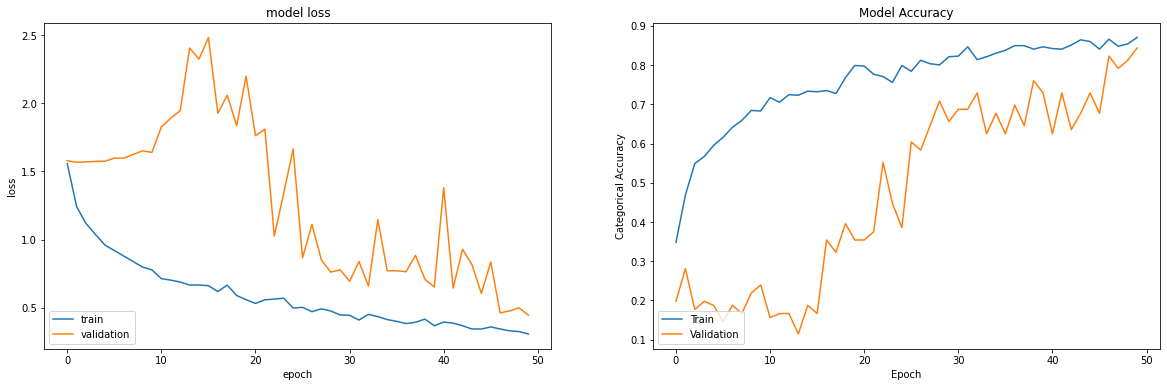

In [ ]:
model_9 = plot_history(history9)

**Summary Experiment - 9**

**Analysis**

**Image Description:**

The image presents two plots: one depicting the model loss and the other showing the model accuracy over 50 epochs. The x-axis in both plots represents the epochs, while the y-axis shows the loss and accuracy, respectively. Both plots include lines for the training and validation sets.

**Scores (Assuming values from the previous analysis):**

- Categorical Accuracy - 0.8705
- Categorical Loss - 0.3073
- Val_Categorical Accuracy - 0.8438
- Val_Categorical Loss - 0.4454

**Conclusion:**
- Here we can Categorical Accuracy & Val_Categorical Accuracy score is more than 80% which good score compared to above models.
- The model built with Time distributed Conv2D and ConvLSTM2D (Experiment - 9) gave better results compared to all other models and also the model have very least number of parameters compared to other models